<a href="https://colab.research.google.com/github/jaideep6214/Time-Series-Analysis-Sunspot-Data-/blob/master/SunSpots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/DeepLearning/Time Series/Sun Spot/Sunspots.csv',header=0)

In [ ]:
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [ ]:
time_step = []
sunspots = []

with open('/content/gdrive/My Drive/DeepLearning/Time Series/Sun Spot/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)                            #Creating Time Steps and Mean as Time Series
time = np.array(time_step)

series = np.array(sunspots)
time = np.array(time_step)

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

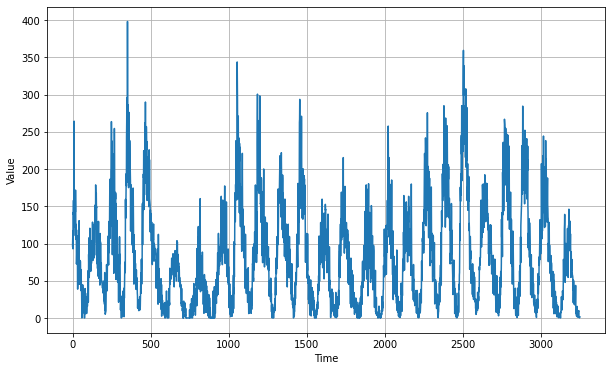

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
len(series) #We have 3252 series split it into 3000 test and 252 validation

3252

In [ ]:
split_time = 3000
x_train = series[:split_time]     #Splitting the series into x_train and x_validate
x_valid = series[split_time:]

time_train = time[:split_time]    #Splitting our time steps that is 1,2,3,4 
time_valid = time[split_time:]

In [ ]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
#Simple Neural Network
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):  #Creating dataset for Simple Neural Network
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
#Simple Neural Network
dataset1 = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
#Simple Neural Network
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [ ]:
#Simple Neural Network
model1.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
history1 =model1.fit(dataset1,epochs=100,verbose=0)

In [ ]:
#Simple Neural Network
forecast=[]
#series[time:time + window_size][np.newaxis] is the 30 elements which we send to our model and it will predict the 31st output

for time in range(len(series) - window_size):
  forecast.append(model1.predict(series[time:time + window_size][np.newaxis]))  #numpy new axis reshapes it to input used by model

print(len(forecast))  #Predicted 30 + 3222 values

forecast = forecast[split_time-window_size:] #took forecast after the split, i.e discarded the test prediction and kept validation prediction
results = np.array(forecast)[:, 0, 0] # taking out from boxes


3222


In [ ]:
'''
Explaination
window size=2
15-2= 13 times loops 
for 0=>0:2 it will give 2 with the help of 0 and 1
for 1=>1:3 it will give 3 with the help of 1 and 2
for 2=>2:4 it will give 4 with the help of 2 and 3
....
for 12=>12:14 it will give 14 with the help of 12 and 13
i predicted 13 values
10-2 =8 discarded
5 is my prediction = validation
0 1 2 3 4 5 6 7 8 9 |10 11 12 13 14 
_ _ * * * * * * * *  *  *  *  *  * 


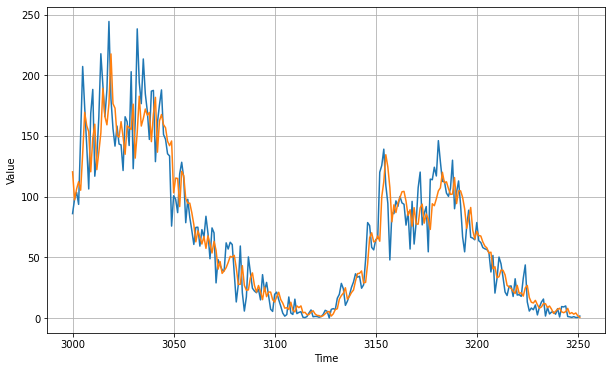

In [ ]:
#Simple Neural Network
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
#Simple Neural Network
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

13.793371

In [ ]:
#Using LSTM 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [ ]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu",input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model2.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model2.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
24/24 [==============================] - 2s 79ms/step - loss: 137.2642 - mae: 137.7642 - lr: 1.0000e-08
Epoch 2/100
24/24 [==============================] - 2s 75ms/step - loss: 124.3935 - mae: 124.8934 - lr: 1.1220e-08
Epoch 3/100
24/24 [==============================] - 2s 77ms/step - loss: 110.2697 - mae: 110.7696 - lr: 1.2589e-08
Epoch 4/100
24/24 [==============================] - 2s 76ms/step - loss: 96.8557 - mae: 97.3554 - lr: 1.4125e-08
Epoch 5/100
24/24 [==============================] - 2s 76ms/step - loss: 83.9904 - mae: 84.4898 - lr: 1.5849e-08
Epoch 6/100
24/24 [==============================] - 2s 76ms/step - loss: 71.5914 - mae: 72.0902 - lr: 1.7783e-08
Epoch 7/100
24/24 [==============================] - 2s 76ms/step - loss: 60.2195 - mae: 60.7173 - lr: 1.9953e-08
Epoch 8/100
24/24 [==============================] - 2s 74ms/step - loss: 51.1243 - mae: 51.6217 - lr: 2.2387e-08
Epoch 9/100
24/24 [==============================] - 2s 75ms/step - loss: 44.9011 

(1e-08, 0.0001, 0.0, 30.0)

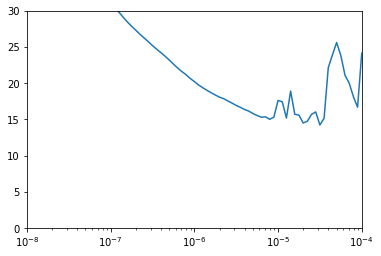

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu",input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model3.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model3.fit(train_set,epochs=100)

Epoch 1/100
24/24 [==============================] - 2s 74ms/step - loss: 34.6112 - mae: 35.1072
Epoch 2/100
24/24 [==============================] - 2s 73ms/step - loss: 24.0726 - mae: 24.5668
Epoch 3/100
24/24 [==============================] - 2s 75ms/step - loss: 20.2192 - mae: 20.7123
Epoch 4/100
24/24 [==============================] - 2s 75ms/step - loss: 18.0880 - mae: 18.5802
Epoch 5/100
24/24 [==============================] - 2s 73ms/step - loss: 17.1665 - mae: 17.6584
Epoch 6/100
24/24 [==============================] - 2s 74ms/step - loss: 16.4559 - mae: 16.9471
Epoch 7/100
24/24 [==============================] - 2s 73ms/step - loss: 16.1405 - mae: 16.6316
Epoch 8/100
24/24 [==============================] - 2s 75ms/step - loss: 15.5206 - mae: 16.0111
Epoch 9/100
24/24 [==============================] - 2s 75ms/step - loss: 16.8011 - mae: 17.2925
Epoch 10/100
24/24 [==============================] - 2s 73ms/step - loss: 15.9523 - mae: 16.4436
Epoch 11/100
24/24 [=========

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
rnn_forecast = model_forecast(model3, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

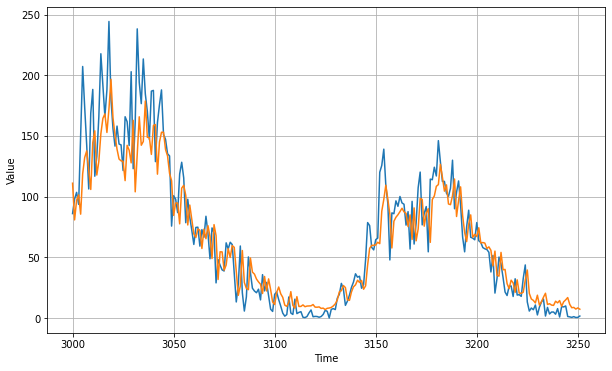

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.765834

<Figure size 432x288 with 0 Axes>

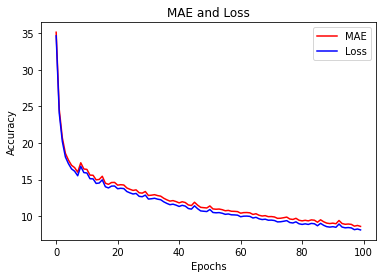

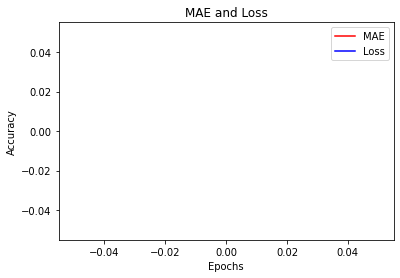

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
#Using Everything
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
window_size = 60 # Learning from 20 points and predicting the 21st
batch_size = 64
shuffle_buffer_size = 1000 #speeding up the training

In [ ]:

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [ ]:

model4 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu",input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(10,activation="relu"),
  tf.keras.layers.Dense(10,activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model4.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model4.fit(train_set,epochs=100, callbacks=[lr_schedule])

Epoch 1/100
23/23 [==============================] - 3s 146ms/step - loss: 72.2864 - mae: 72.7840 - lr: 1.0000e-08
Epoch 2/100
23/23 [==============================] - 3s 148ms/step - loss: 71.6043 - mae: 72.1018 - lr: 1.1220e-08
Epoch 3/100
23/23 [==============================] - 3s 148ms/step - loss: 70.8258 - mae: 71.3234 - lr: 1.2589e-08
Epoch 4/100
23/23 [==============================] - 3s 146ms/step - loss: 70.0380 - mae: 70.5357 - lr: 1.4125e-08
Epoch 5/100
23/23 [==============================] - 3s 146ms/step - loss: 69.2387 - mae: 69.7365 - lr: 1.5849e-08
Epoch 6/100
23/23 [==============================] - 3s 146ms/step - loss: 68.4143 - mae: 68.9120 - lr: 1.7783e-08
Epoch 7/100
23/23 [==============================] - 3s 148ms/step - loss: 67.5563 - mae: 68.0540 - lr: 1.9953e-08
Epoch 8/100
23/23 [==============================] - 5s 233ms/step - loss: 66.6600 - mae: 67.1579 - lr: 2.2387e-08
Epoch 9/100
23/23 [==============================] - 6s 262ms/step - loss: 65.71

(1e-08, 0.0001, 0.0, 30.0)

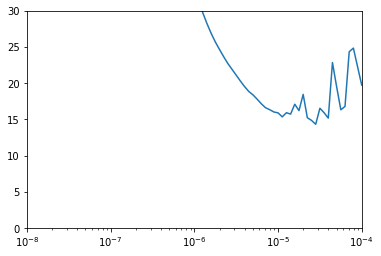

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
window_size = 30 # Learning from 20 points and predicting the 21st
batch_size = 32
shuffle_buffer_size = 1000 #speeding up the training

In [ ]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

In [ ]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 5, strides=1, padding="same", activation="relu", input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

# optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model4.compile(loss=tf.keras.losses.Huber(),optimizer='adam',metrics=["mae"])
history = model4.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 7s 71ms/step - loss: 12.7583 - mae: 13.2446
Epoch 2/100
93/93 [==============================] - 7s 72ms/step - loss: 5.4454 - mae: 5.9148
Epoch 3/100
93/93 [==============================] - 7s 72ms/step - loss: 3.9946 - mae: 4.4510
Epoch 4/100
93/93 [==============================] - 7s 73ms/step - loss: 3.4663 - mae: 3.9190
Epoch 5/100
93/93 [==============================] - 7s 73ms/step - loss: 3.9792 - mae: 4.4366
Epoch 6/100
93/93 [==============================] - 7s 71ms/step - loss: 2.3611 - mae: 2.7886
Epoch 7/100
93/93 [==============================] - 7s 73ms/step - loss: 3.3053 - mae: 3.7532
Epoch 8/100
93/93 [==============================] - 7s 73ms/step - loss: 3.8042 - mae: 4.2641
Epoch 9/100
93/93 [==============================] - 7s 73ms/step - loss: 2.7152 - mae: 3.1441
Epoch 10/100
93/93 [==============================] - 7s 72ms/step - loss: 2.7675 - mae: 3.2082
Epoch 11/100
93/93 [===========================

In [ ]:
rnn_forecast = model_forecast(model4, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

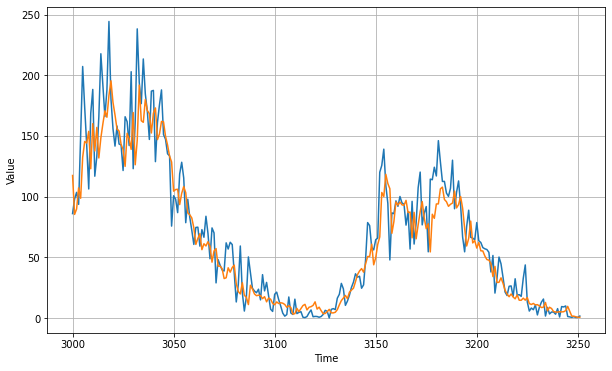

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.263876

<Figure size 432x288 with 0 Axes>

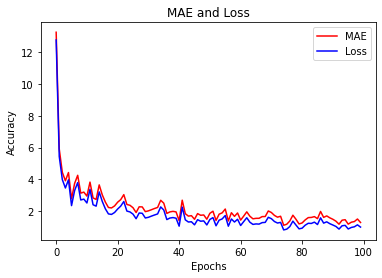

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()



In [ ]:
model4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 64)          384       
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 128)         66048     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, None, 128)         98816     
_________________________________________________________________
dense_17 (Dense)             (None, None, 32)          4128      
_________________________________________________________________
dense_18 (Dense)             (None, None, 16)          528       
_________________________________________________________________
dense_19 (Dense)             (None, None, 1)           17        
_________________________________________________________________
lambda_9 (Lambda)            (None, None, 1)          

In [ ]:
#Saving Model
model_json = model4.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model4.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
# Retrieving model
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('/content/gdrive/My Drive/DeepLearning/Time Series/Sun Spot/model_sunspot.json', 'r') as f:
    fmodel = tf.keras.models.model_from_json(f.read())


# Load weights into the new model
fmodel.load_weights('/content/gdrive/My Drive/DeepLearning/Time Series/Sun Spot/model_sunspot.h5')

In [ ]:
fmodel.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 64)          384       
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 128)         66048     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, None, 128)         98816     
_________________________________________________________________
dense_17 (Dense)             (None, None, 32)          4128      
_________________________________________________________________
dense_18 (Dense)             (None, None, 16)          528       
_________________________________________________________________
dense_19 (Dense)             (None, None, 1)           17        
_________________________________________________________________
lambda_9 (Lambda)            (None, None, 1)          